# Final Investigation Project: Find Your Ideal House at King County
### Author: Zhongling Jiang

**Project Description**:

The project revolves around two datasets that are downloaded from [Kaggle](https://www.kaggle.com/harlfoxem/housesalesprediction) and governemnt zip code database. The primary dataset, King County housing dataset records sales prices of homes sold between May 2014 and May 2015 in King County. The complementary dataset, zip code dataset, contains US zip code and corresponding region names and geological information.

My main goal is to build a reasonable model to predict housing prices using 19 house features given, and then try to interpret the result. But before that, I would like to explore the dataset through visualization, hypothesis testing, etc, in order to achieve some potentially useful conclusions. For example, the question that whether waterfront houses are often more expensive than non-waterfront houses, and the relationship between location of pricy houses and different districts. After completing this step, I use two versions of linear models (OLS and Lasso) to fit the data 
and then pick one that I think is more accurate.       

In [1]:
from datascience import *
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plots
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split  
import warnings

warnings.filterwarnings('ignore')

plots.style.use('fivethirtyeight')
%matplotlib inline

# King County Housing dataset

numerical variables: price, bedrooms, bathrooms, sqft_living, sqft_lot, floors, sqft_above, sqft_basement, sqft_living15, sqft_lot15

categorical variables: waterfront, view, condition, grade

other variables: id, date,yr_built, yr_renovated, zipcode, lat, long

In [2]:
housing = Table.read_table('house_data.csv')
housing.show(5)

id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
7129300520,20141013T000000,221900,3,1,1180,5650,1,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
6414100192,20141209T000000,538000,3,2.25,2570,7242,2,0,0,3,7,2170,400,1951,1991,98125,47.721,-122.319,1690,7639
5631500400,20150225T000000,180000,2,1,770,10000,1,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2487200875,20141209T000000,604000,4,3,1960,5000,1,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
1954400510,20150218T000000,510000,3,2,1680,8080,1,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [3]:
zip_code = Table.read_table('zip_codes.csv')
zip_code.show(5)

description,name,PONAME,ZIP,latitude,POP2001,STATE,AREA,zip2,longitude,SUMBLKPOP,geometry
nan,Zip:,MT MEADOWS AREA,12,40.2487,60,CA,44.9238,12,-120.959,147,-120. ...
nan,Zip:,WEST PIMA COUNTY,14,32.1846,80,AZ,1231.6,14,-113.026,83,-112. ...
nan,Zip:,CORONADO NTL FOREST,15,32.3739,206,AZ,430.679,15,-110.657,176,-110. ...
nan,Zip:,SEQUOIA NATIONAL FOREST,16,35.51,8,CA,124.153,16,-118.357,8,-118. ...
nan,Zip:,NORTHEAST FRESNO COUNTY,17,37.1711,63,CA,1168.75,17,-118.929,62,-119. ...


## Part I Visualization

In this part, I would like visualize some single numerical variable and catogorical variable, as well as between two variables, in order to help discover some potential relationship among them.

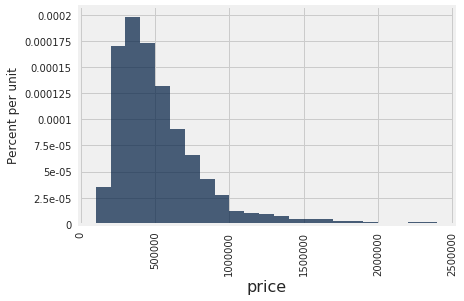

In [4]:
# The distribution of price, our target variable
bins = np.arange(100000, 2500000, 100000)
housing.hist('price', bins = bins)

In [5]:
def IQR_and_mean(array):
    print ('The mean of the variable is: ', np.mean(array))
    return make_array([percentile(25,array), percentile(75,array)])

IQR_and_mean(housing.column('price'))

The mean of the variable is:  540088.141767


array([[ 321950.,  645000.]])

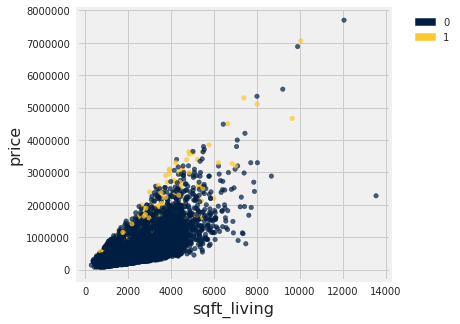

In [6]:
# want to see the relationship between price and sqft, plus waterfront
housing.scatter('sqft_living', 'price', colors='waterfront')

The plot displays a **positive** correlation between price and sqft_living, which quite matches our sense. However, the variance of price increases as living square footage increases. We do want to avoid this issue, becuase it could bring problems to our model.

What we also could see from the graph is that waterfront houses are comparatively **more expensive** than non-waterfront houses as the yellow colored points float above blue points with the same sqft_living. This shows that a categorical variable can also affect our model, as the mean of each category could differ. To confirm this, I use group function to check their means and standard deviations.

In [7]:
w = housing.group('waterfront', collect = np.mean).select( 'waterfront', 'price mean').with_column('price std', housing.group('waterfront', np.std).column('price std'))
w

waterfront,price mean,price std
0,531564,341592
1,1.66188e+06,1.11693e+06


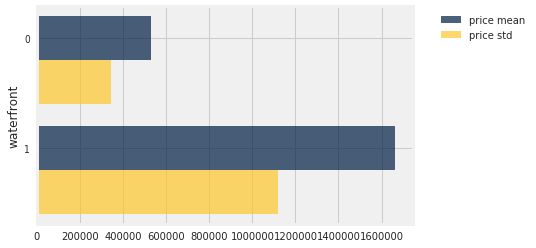

In [8]:
w.barh(0)

Although the mean price of waterfront houses are much higher than non-waterfront houses, the variance is also higher. Therefore, we **cannot precisely tell** from the graph that whether there is a significant correlation between waterfront and house price, due to the reason of chance effect. 




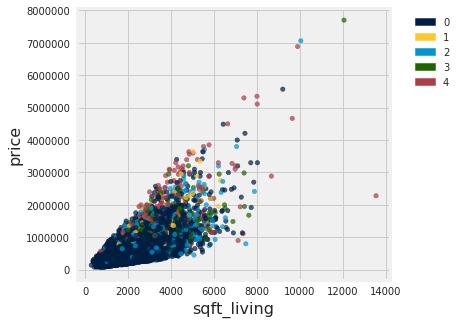

In [9]:
housing.scatter('sqft_living', 'price', colors='view')

In [10]:
w2 = housing.group('view', np.mean).select( 'view', 'price mean').with_column('price std', housing.group('view', np.std).column('price std'))
w2


view,price mean,price std
0,496564,287126
1,812281,510180
2,792401,509840
3,971965,612091
4,1.46371e+06,950716


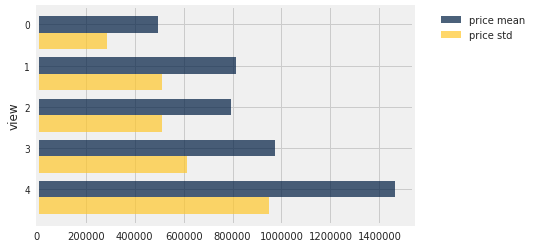

In [11]:
w2.barh(0)

However, we can see that both categorical variables lead to difference in mean price, but standard deviations are also different. We want to measure **whether the variable truly makes a difference in price, and therefore we need to run an experiment and make a hypothesis test**. Let's start from the variable **'waterfront'**.

## PART II: Hypothesis Testing: Being Waterfront

H0: The waterfront = 0 or 1 does not influence mean housing price. mu1 - mu0 = 0

Ha: The waterfront = 0 or 1 influences mean housing price. mu1 - mu0 != 0 

The test statistic is difference in mean housing price of two categories: **mu1 - mu0**. The experiment principle is that if a house being waterfront has no influence over price, then by randomly assigning housing price to either category shall not cause too large difference in mean housing price in two categories.

In [12]:
## Original data
price_view = housing.select('price', 'waterfront') 
test_stat = np.diff(price_view.group('waterfront', np.mean).column('price mean'))
## function that resamples 

def random_assign(table):
    new_price = table.select('price').sample(with_replacement = False).column('price')
    return table.select('waterfront').with_column('price', new_price)
def test(table):
    test_statistics = make_array()
    for i in np.arange(1000):
        price_view_table = random_assign(table)
        test_stat = np.diff(price_view_table.group('waterfront', np.mean).column('price mean'))
        test_statistics = np.append(test_statistics, test_stat)
    return test_statistics


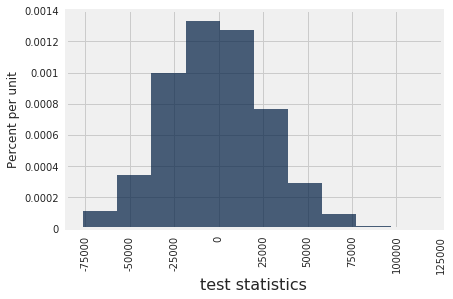

In [13]:
# plot histogram and calculate p-value
diff_dist = test(price_view)
Table().with_column('test statistics', diff_dist).hist()

In [14]:
## look at confidence interval, and make our conclusion
confint = make_array([percentile(2.5,diff_dist), percentile(97.5,diff_dist)])
obs_test_stat = np.diff(price_view.group('waterfront', np.mean).column('price mean'))
print ('The 95% confidence interval is :' , confint , ', and the our observed test statistics is: ', obs_test_stat)

The 95% confidence interval is : [[-54962.99677063  53975.96251634]] , and the our observed test statistics is:  [ 1130312.42472636]


### Conclusion:
The observed difference is far **greater** than top bound of our interval, so we choose to reject the null hypothesis and conclude the fact that whether a house is waterfront **has a significant effect** on house price 

## Part III: Joins, Geographics and Housing Price 

In [15]:
## JOIN two datasets 
zip_select = zip_code.select('PONAME', 'ZIP', 'STATE', 'AREA')
housing_location = housing.join('zipcode', zip_select, 'ZIP')

In [16]:
housing_location.select('zipcode', 'price', 'PONAME', 'STATE', 'AREA').show(5)

zipcode,price,PONAME,STATE,AREA
98001,240000,AUBURN,WA,18.6218
98001,287000,AUBURN,WA,18.6218
98001,480000,AUBURN,WA,18.6218
98001,465000,AUBURN,WA,18.6218
98001,360000,AUBURN,WA,18.6218


In [17]:
## Pivot Table shows relationship between two categorical variables.
housing_location.group('STATE')

STATE,count
WA,21159


In [18]:
housing_location.group('PONAME').num_rows == housing_location.group('zipcode').num_rows

False

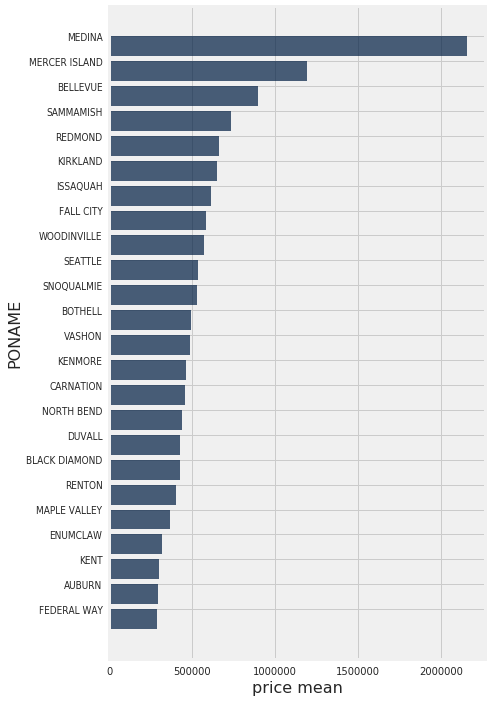

In [19]:
price_by_district = housing_location.group('PONAME', np.mean).select('PONAME','price mean').sort('price mean', descending = True)
price_by_district.barh(0)

In [20]:
## Lets plot the top ten expensive house and lowest ten expensive house on the map

top_30 = housing_location.sort('price', descending= True). take(np.arange(30)).select('zipcode', 'price', 'lat', 'long','PONAME', 'STATE', 'AREA')
top_30
Marker.map_table(top_30.select('lat', 'long', 'PONAME'))

In [21]:
lowest_30 = housing_location.sort('price', descending= False). take(np.arange(30)).select('zipcode', 'price', 'lat', 'long','PONAME', 'STATE', 'AREA')
lowest_30
Marker.map_table(lowest_30.select('lat', 'long', 'PONAME'))

### Conclusions

The graph has clearly shown expensive houses are distributed on two riversides of Lake Washington: districts like 
**Medina, Bellevue, MercerIsland**.
    
Cheap houses are at southsides of Lake Washington, further in land area. These districts include: **Kent, Aurburn, Federal Way**

**Seattle** has both cheap and expensive houses. The closer to water, the more expensive.

## Part III: Modeling: Estimate Your Housing Budget

In part II, I will build a generalized linear model on price varaible against other variables. The goal is to see which variables play important roles in predicting housing prices.

In [22]:
## Transforming the data
housing2 = housing.drop(['id','date', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15'])
housing2

price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement
221900,3,1,1180,5650,1,0,0,3,7,1180,0
538000,3,2.25,2570,7242,2,0,0,3,7,2170,400
180000,2,1,770,10000,1,0,0,3,6,770,0
604000,4,3,1960,5000,1,0,0,5,7,1050,910
510000,3,2,1680,8080,1,0,0,3,8,1680,0
1.225e+06,4,4.5,5420,101930,1,0,0,3,11,3890,1530
257500,3,2.25,1715,6819,2,0,0,3,7,1715,0
291850,3,1.5,1060,9711,1,0,0,3,7,1060,0
229500,3,1,1780,7470,1,0,0,3,7,1050,730
323000,3,2.5,1890,6560,2,0,0,3,7,1890,0


In [23]:
print('The size of test size is: ' , int(housing2.num_rows/10))
print('The size of training size is: ', housing2.num_rows - int(housing2.num_rows/10))

The size of test size is:  2161
The size of training size is:  19452


In [24]:
# This step involves normalizing all numerical variables in the table. 
categorical_vars = ['view']
numerical_vars = [i for i in housing2.labels if i not in categorical_vars]

def normalize(array):
    return (array - np.mean(array))/np.std(array)

def norm_table(t):
    new_t = Table()
    for label in t.labels:
        if label in categorical_vars:
            new_t = new_t.with_column(label, t.column(label))
        else:
            new_t = new_t.with_column(label, normalize(t.column(label)))
    return new_t


In [25]:
norm_housing2 = norm_table(housing2)
norm_housing2

price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement
-0.866717,-0.398737,-1.44746,-0.979835,-0.228321,-0.915427,-0.0871726,0,-0.629187,-0.558836,-0.734708,-0.658681
-0.00568792,-0.398737,0.175607,0.533634,-0.189885,0.936506,-0.0871726,0,-0.629187,-0.558836,0.460841,0.245141
-0.980849,-1.47396,-1.44746,-1.42625,-0.123298,-0.915427,-0.0871726,0,-0.629187,-1.40959,-1.22983,-0.658681
0.17409,0.676485,1.14945,-0.13055,-0.244014,-0.915427,-0.0871726,0,2.44429,-0.558836,-0.891699,1.39752
-0.0819575,-0.398737,-0.149007,-0.435422,-0.169653,-0.915427,-0.0871726,0,-0.629187,0.291916,-0.130895,-0.658681
1.86564,0.676485,3.09713,3.63679,2.09618,-0.915427,-0.0871726,0,-0.629187,2.84417,2.53796,2.79844
-0.769746,-0.398737,0.175607,-0.397313,-0.200098,0.936506,-0.0871726,0,-0.629187,-0.558836,-0.0886284,-0.658681
-0.67618,-0.398737,-0.798235,-1.11049,-0.130276,-0.915427,-0.0871726,0,-0.629187,-0.558836,-0.879623,-0.658681
-0.846016,-0.398737,-1.44746,-0.326539,-0.184381,-0.915427,-0.0871726,0,-0.629187,-0.558836,-0.891699,0.990795
-0.59133,-0.398737,0.500221,-0.206768,-0.206351,0.936506,-0.0871726,0,-0.629187,-0.558836,0.122706,-0.658681


In [26]:
housing2 = norm_housing2
housing2 = housing2.to_df()

### (i) Fitting Ordinary Linear Model 

Coefficients: 
 bedrooms        -8.816542e-02
bathrooms       -2.762590e-02
sqft_living     -2.210515e+12
sqft_lot        -3.841575e-02
floors          -5.346584e-03
waterfront       1.336137e-01
view             1.660885e-01
condition        9.071270e-02
grade            3.240213e-01
sqft_above       1.993059e+12
sqft_basement    1.065195e+12
dtype: float64
Mean squared error: 0.43
Variance score: 0.62


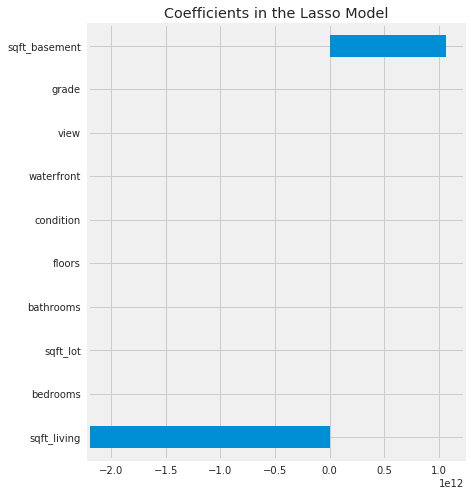

In [32]:
# The commented part is what I previsouly written for train/test split, but later I found it unconvenient to use, especially
#when I need to transform some variables. Therefore I use sklearn train_test_split function.  

#def generate_train_test(housing2):

#    test_size = int(housing2.num_rows/10)
#    training_size = housing2.num_rows - int(housing2.num_rows/10)
#    housing2_resample = housing2.sample(with_replacement=False)

#    training_X = housing2_resample.take(np.arange(training_size)).drop('price').to_df()
#    training_Y = housing2_resample.take(np.arange(training_size)).select('price').to_df()
#    test_X = housing2_resample.take(np.arange(training_size + 1, housing2.num_rows)).drop('price').to_df()
#    test_Y = housing2_resample.take(np.arange(training_size + 1, housing2.num_rows)).select('price').to_df()
#   return (training_X, training_Y, test_X, test_Y)

from sklearn import linear_model

training_X, testing_X, training_Y, testing_Y = train_test_split(housing2.drop(['price'], axis = 1), housing2['price'], test_size=0.2, random_state=42)

def fit_model(train_X, train_Y, test_X, test_Y):
    regr = linear_model.LinearRegression()
    regr.fit(train_X, train_Y)
    # The coefficients
    coef = pd.Series(regr.coef_, index = train_X.columns)
    print('Coefficients: \n', coef)
    
    import matplotlib
    imp_coef =coef.sort_values().head(10)

    matplotlib.rcParams['figure.figsize'] = (6.0, 8.0)
    imp_coef.plot(kind = "barh")
    plots.title("Coefficients in the Lasso Model")
    
    # The mean squared error
    print("Mean squared error: %.2f" % np.mean((regr.predict(test_X) - test_Y) ** 2))
    # Explained variance score: 1 is perfect prediction
    print('Variance score: %.2f' % regr.score(test_X, test_Y))
    print

fit_model(training_X, training_Y, testing_X, testing_Y)

**Observation**: The fitting of OLS returns an array of coefficients of all these variables. The variance score is 0.62. However, we find most coefficients are reduced to zero, only two coefficients are significant. **This is a sign of multicollinearity**. That means multiple variables are highly correlated to each other, so that many originally significant variables have their coefficeints dimimished to zero. In order to validify this, there are something we need to look at.

### Model Diagnostics

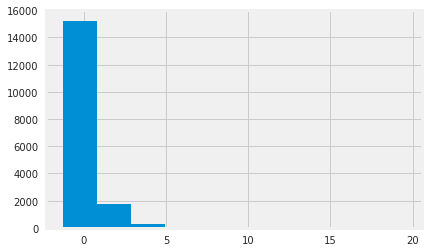

In [28]:
## checking the distribution in train_and_test 
training_Y.hist()

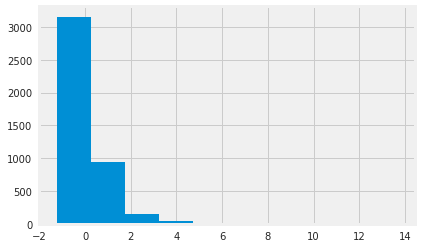

In [29]:
testing_Y.hist()

The price distribution in train and test set are similar, so the split process is random.

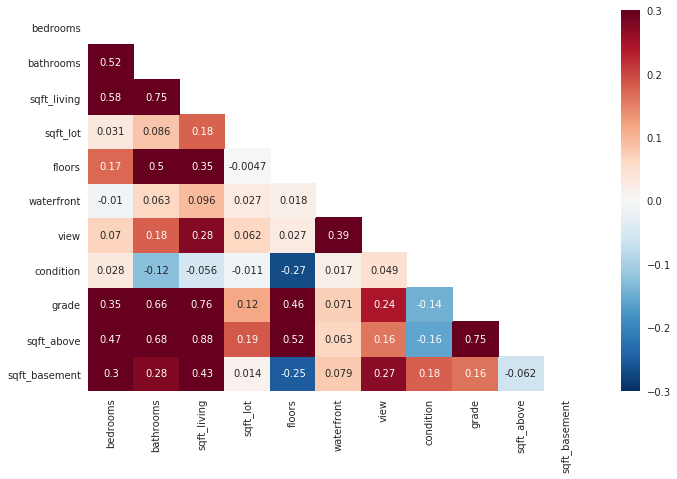

In [33]:
#To further investigate the correlation among all variables, I create a correlation plot, which shows correlation between each pair of variables. 
plots.figure(figsize=(10, 7))
mask = np.zeros_like(training_X.corr())
mask[np.triu_indices_from(mask)] = True
with sns.axes_style('white'):
    ax = sns.heatmap(training_X.corr(), mask=mask, vmax=.3, annot=True)

In [30]:
correlation = training_X.corr()
correlation[correlation > 0.6]

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement
bedrooms,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
bathrooms,NaN,1.000000,0.752745,NaN,NaN,NaN,NaN,NaN,0.664407,0.683303,NaN
sqft_living,NaN,0.752745,1.000000,NaN,NaN,NaN,NaN,NaN,0.760652,0.875820,NaN
sqft_lot,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
floors,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
waterfront,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
view,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
condition,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
grade,NaN,0.664407,0.760652,NaN,NaN,NaN,NaN,NaN,1.000000,0.752990,NaN
sqft_above,NaN,0.683303,0.875820,NaN,NaN,NaN,NaN,NaN,0.752990,1.000000,NaN


#### Variance Inflation Factor (VIF)

In [36]:
## Any Multicollinearity among multiple (more than two varibles
vif = [variance_inflation_factor(training_X.values, i) for i in range(training_X.shape[1])]
print(vif)
print(training_X.columns)

[1.6347075862274338, 2.9438022146013507, inf, 1.0610121698286421, 1.846619100416889, 1.1653784390591031, 1.295814526435676, 1.1060629325607061, 2.8674692252623584, inf, inf]
Index(['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement'],
      dtype='object')


**Observation**: I find that some variables are highly correlated, and this might affect the performance of the model.These variables include **[(sqft_living, sqft_above), (sqft_living, grade), (bathrooms, sqft_living), (bathrooms, sqft_above)]**. In order to avoid multicollinearity, I fit a Lasso regression model to the data. Becuase Lasso can reduce some redundant variables' coefficients to zero.     

### (ii) Fitting a Lasso Model  

In [38]:
# Lasso Regression
from sklearn.linear_model import LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score

def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, training_X, training_Y, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)

model_lasso = LassoCV(alphas = [1, 0.5, 0.1, 0.05, 0.01, 0.001, 0.0005]).fit(training_X, training_Y)
print('The average errror rate is: ',rmse_cv(model_lasso).mean())

coef = pd.Series(model_lasso.coef_, index = training_X.columns)

print(coef)
def fit_lasso():
    reg = linear_model.Lasso(alpha = 0.1)
    

The average errror rate is:  0.620968695768
bedrooms        -0.081097
bathrooms       -0.023968
sqft_living      0.465729
sqft_lot        -0.037113
floors          -0.004350
waterfront       0.132531
view             0.167479
condition        0.090053
grade            0.323133
sqft_above       0.000000
sqft_basement    0.036410
dtype: float64


### The following plot gives an importance ranking of all features in determining housing prices

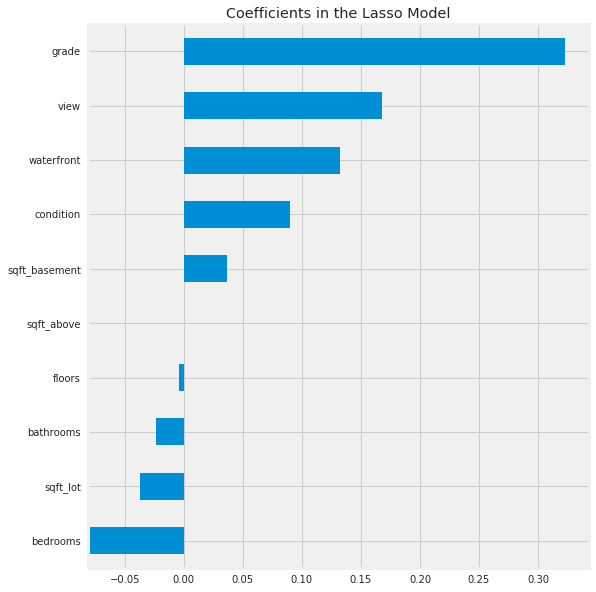

In [35]:
import matplotlib
imp_coef =coef.sort_values().head(10)

matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plots.title("Coefficients in the Lasso Model")

**Observation**: This time more variables become significant. According to the lasso result, The grade of the housing, the view, and being waterfront are three important factors that affect housing price most. On the other hand, number of bedrooms, size of parking lot, number of bathrooms negatively impact housing prices. 

And I can use the following funciton to find the prediction error for different models:

In [38]:
## Calculate the Error Rate
def error(result):
    prediction = result.predict(test_X)
    SSE = sum((test_Y - prediction) ** 2)
    return SSE

## Conclusion

The project mainly performs an investigation on housing prices in King County, WA. From the previous steps, the result tells us following things:

1. Waterfront Houses are **more expensive** than non-waterfront houses, and the difference is not due to chance. 

2. In this context, waterfront houses refer to houses near Washington Lake. From joining zip code table, I find that residential districts close to the Lake (Medina, Bellevue, MercerIsland) indeed has a higher average housing price than inland districts (Kent, Aurburn, Federal Way). Top30, Low30 houses are plotted on map to verify this result.

3. Lasso model gives an **importance feature ranking**, which gives housebuyers an idea of what factors may decide higher house prices. 


Although the lasso model has given me a lot of information, this hasn't been an end to this investigation. More better models could be attempted on this dataset, like decision tree, etc, to capture more details of these features characteristics. And also, transforming the response variable (using log) and fitting a generalized linear model could be another option if looking for higher accuracy. They are not discussed in detail here in this project.  

In [ ]:
# Run this cell to 
# - create necessary support files, 
# - check that your exploration is formatted correctly, 
# - and submit your work to OK.

ok_spec = """
{
  "name": "Independent Data Exploration",
  "endpoint": "cal/data8/sp17/exploration",
  "src": [
    "exploration.ipynb"
  ],
  "tests": {},
  "protocols": [
      "file_contents",
      "backup"
  ]
}    
"""
    
ok_test = '''
test = {
  'name': 'Check file name',
  'points': 1,
  'suites': [
    {
      'cases': [
        {
          'code': r"""
          >>> # Make sure that you name your submission file exploration.ipynb
          >>> import os
          >>> os.path.exists('exploration.ipynb')
          True
          """,
          'hidden': False,
          'locked': False
        },
      ],
      'scored': True,
      'setup': '',
      'teardown': '',
      'type': 'doctest'
    }
  ]
}
'''
    
import os
    
if not os.path.exists('exploration.ok'):
    with open('exploration.ok', 'w') as out:
        out.write(ok_spec)

if not os.path.exists('tests/q1.py'):
    with open('tests/q1.py', 'w') as out:
        out.write(ok_test)
    
from client.api.notebook import Notebook
ok = Notebook('exploration.ok')
ok.auth(inline=True)
ok.grade('q1')
_ = ok.submit()

Assignment: Independent Data Exploration
OK, version v1.9.5

Successfully logged in as jzljohn18@berkeley.edu
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Saving notebook... 